#### Funding

In [ ]:
def get_thresholds():
    data = []
    with open('./bot/config/thresholds.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Удаляем пробелы и переносы строк
            if line:  # Игнорируем пустые строки
                # Преобразуем строку в кортеж с помощью literal_eval
                tuple_data = ast.literal_eval(line)
                data.append(tuple_data)
    return data

In [ ]:
from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI, GateIORestAPI

import pandas as pd
import polars as pl
import numpy as np
# pd.options.display.float_format = '{:.2f}'.format
from datetime import datetime, timezone, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

from bot.utils.files import get_saved_coins

In [ ]:
async def get_data(symbol, interval, n_iters, exchange):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df[f'{exchange}_linear'].sort_index()
    return df.dropna()

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [ ]:
exchange = 'bybit'

token_list = [
            '1INCH_USDT',
            'ACH_USDT', 'ADA_USDT', 'AGLD_USDT', 'ALGO_USDT', 'APT_USDT', 'ARB_USDT', 'ARKM_USDT', 'ATOM_USDT',
            'BLUR_USDT',
            'CELO_USDT', 'CHZ_USDT', 'CRV_USDT',
            'DOGE_USDT', 'DOT_USDT', 'DRIFT_USDT', 'DYDX_USDT',
            'EGLD_USDT', 'ENA_USDT', 'ETHFI_USDT', 'FARTCOIN_USDT', 'FLOW_USDT',
            'GALA_USDT', 'GLM_USDT', 'GMT_USDT', 'GRT_USDT',
            'HBAR_USDT', 'IMX_USDT', 'INJ_USDT', 'IOTA_USDT',
            'JASMY_USDT', 'JUP_USDT', 'KAS_USDT', 'KSM_USDT',
            'LDO_USDT', 'LPT_USDT',
            'MANA_USDT', 'MANTA_USDT', 'MORPHO_USDT', 'MOVE_USDT',
            'NEAR_USDT', 'NXPC_USDT',
            'ONDO_USDT', 'OP_USDT', 'ORDI_USDT',
            'PNUT_USDT', 'POL_USDT', 'RENDER_USDT', 'ROSE_USDT', 'RUNE_USDT',
            'S_USDT', 'SAND_USDT', 'SEI_USDT', 'STRK_USDT',
            'STX_USDT', 'SUI_USDT', 'SUSHI_USDT',
            'THETA_USDT', 'TIA_USDT', 'TON_USDT', 'TRX_USDT', 'VET_USDT',
            'WIF_USDT', 'XLM_USDT', 'XRP_USDT', 'ZRX_USDT'
              ]

syms = [col[:-5] for col in token_list]

In [ ]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

start_date = datetime.now().replace(microsecond=0) - timedelta(days=60)
end_date = None

for symbol in syms:
    fund_hist = await exc_manager.get_funding_history(symbol=f'{symbol}_USDT', start_date=start_date, limit=500)
    fund_hist = fund_hist[0]

    fund_sum = float(fund_hist['funding'].sum())
    fund_len = fund_hist['funding'].shape[0]

    hour_df = await get_data(symbol=f'{symbol}_USDT', interval='1h', n_iters=5, exchange=exchange)
    hour_df = hour_df.tail(4320) # Берём последние пол года
    hour_df.drop(['Exchange', 'Market_type'], axis=1, inplace=True)
    daily_df = await get_data(symbol=f'{symbol}_USDT', interval='1d', n_iters=1, exchange=exchange)
    daily_df = daily_df.tail(180) # Берём последние пол года

    hour_df['Max_range'] = hour_df['High'] - hour_df['Low']
    hour_df['Max_range_perc'] = (hour_df['High'] - hour_df['Low']) / hour_df['Low'] * 100
    hour_10 = hour_df[hour_df['Max_range_perc'] > 10].shape[0]
    hour_10_perc = 100 * hour_10 / hour_df.shape[0]
    hour_atr = hour_df['Max_range'].mean()
    hour_atr_perc = hour_df['Max_range_perc'].mean()
    hour_mtr_perc = hour_df['Max_range_perc'].max()

    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100
    days_10 = daily_df[daily_df['Max_range_perc'] > 10].shape[0]
    days_10_perc = 100 * days_10 / daily_df.shape[0]
    day_atr = daily_df['Max_range'].mean()
    day_atr_perc = daily_df['Max_range_perc'].mean()
    day_mtr_perc = daily_df['Max_range_perc'].max()

    print(f'========= {symbol} =========')
    print(f'Суммарный фандинг: {fund_sum * 100:.2f}%, расчётов по фандингу: {fund_len}')
    print(f'Фандинг. min: {fund_hist['funding'].min() * 100}%; max: {fund_hist['funding'].max() * 100}%')
    print()
    print(f'ATR за 1 день: {day_atr:.4f} ({day_atr_perc:.2f}%); за 1 час: {hour_atr:.4f} ({hour_atr_perc:.2f}%)')
    print(f'MaxTR за 1 день: {day_mtr_perc:.2f}%; за 1 час: {hour_mtr_perc:.2f}%')
    print(f'Колебания цены более 10%. Дни: {days_10} ({days_10_perc:.1f}%); Часы: {hour_10} ({hour_10_perc:.1f}%)')
    print()

In [ ]:
daily_df

#### Бектест одной торговой пары

In [1]:
from bot.analysis.backtesting import backtest
from bot.utils.pair_trading import *
from bot.analysis.strategy_analysis import analyze_strategy
from bot.indicators.rsi import rsi
from statsmodels.tsa.stattools import adfuller, coint
from hurst import compute_Hc

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import polars as pl
import numpy as np
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

In [2]:
token_1 = 'CRV'
token_2 = 'OP'
min_order = 42
leverage = 6

valid_length = 3
pairs = pl.read_parquet('./data/pair_selection/all_pairs.parquet')
curr_pair = pairs.filter((pl.col('coin1') == token_1) & (pl.col('coin2') == token_2))
std_1 = pairs['std_1'][0]
std_2 = pairs['std_2'][0]

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)

tf = '1h'
winds = np.array([64, 72, 96])

dp_1 = float(coin_information['bybit_linear'][token_1 + '_USDT']['qty_step'])
ps_1 = int(coin_information['bybit_linear'][token_1 + '_USDT']['price_scale'])
dp_2 = float(coin_information['bybit_linear'][token_2 + '_USDT']['qty_step'])
ps_2 = int(coin_information['bybit_linear'][token_2 + '_USDT']['price_scale'])

start_ts = int(datetime.timestamp(valid_time))


In [3]:
tick_df, agg_df = load_data(token_1, token_2, valid_time, end_time, tf, int(max(winds)), db_manager)
tick_df = tick_df.drop(f'{token_1}_size', f'{token_2}_size')

start_ts = int(datetime.timestamp(valid_time))
dist_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, start_ts, 
                             median_length=6, spr_method='dist')
lr_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, start_ts, 
                             median_length=6, spr_method='lr')
tls_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, start_ts, 
                             median_length=6, spr_method='tls')

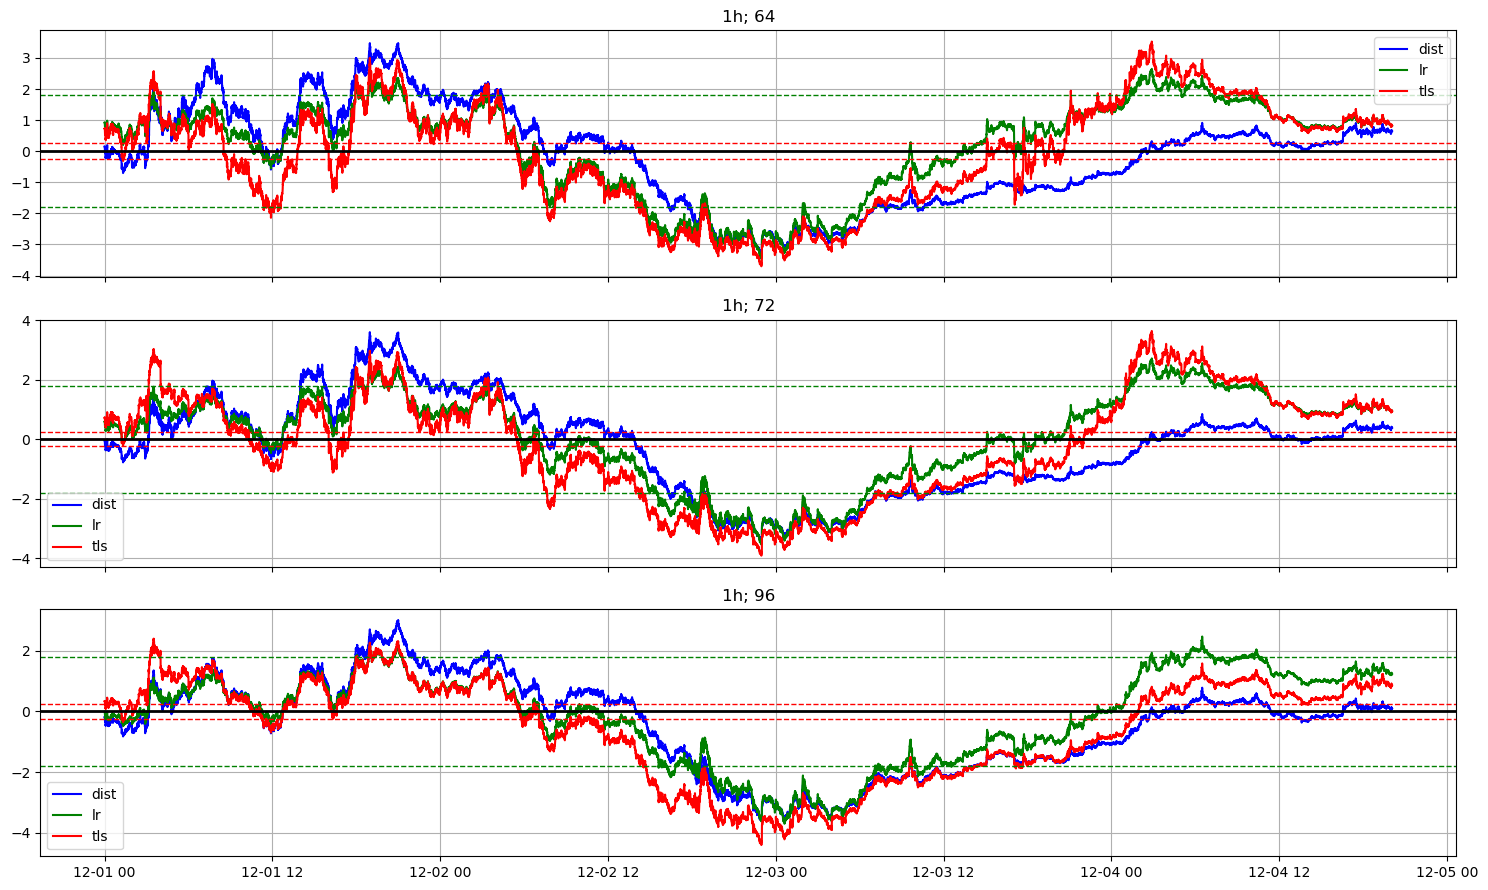

In [4]:
fig, ax = plt.subplots(nrows=len(winds), ncols=1, sharex=True, figsize=(15, 3*len(winds)))
for i, w in enumerate(winds):
    ax[i].plot(dist_df['time'], dist_df[f'z_score_{w}_{tf}'], c='blue', label='dist')
    ax[i].plot(lr_df['time'], lr_df[f'z_score_{w}_{tf}'], c='green', label='lr')
    ax[i].plot(tls_df['time'], tls_df[f'z_score_{w}_{tf}'], c='red', label='tls')
    ax[i].axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax[i].axhline(y=-1.8, color='green', linestyle='--', linewidth=1)
    ax[i].axhline(y=1.8, color='green', linestyle='--', linewidth=1)
    ax[i].axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
    ax[i].axhline(y=0.25, color='red', linestyle='--', linewidth=1)
    ax[i].grid()
    ax[i].set_title(f'{tf}; {w}')
    ax[i].legend()
fig.tight_layout()

In [5]:
# open_time = datetime(2025, 12, 2, 18, 40, 15, tzinfo=ZoneInfo('Europe/Moscow')) # long
open_time = datetime(2025, 12, 1, 19, 6, 35, tzinfo=ZoneInfo('Europe/Moscow')) # short

side_1 = 'short'
side_2 = 'long'
wind = 64

In [6]:
# tick_df.filter(abs(pl.col('time') - start_track_time) < timedelta(seconds=15)).head(1)

In [9]:
lr_df_2h = get_open_time_stats(
            tick_df, agg_df, token_1, token_2, side_1, side_2, open_time, tf, wind, coin_information
        )

In [58]:
lr_df_2h.head(2)

time,ts,CRV,OP,CRV_bid_price,CRV_price,CRV_bid_size,CRV_size,OP_price,OP_ask_price,OP_size,OP_ask_size,spread,spread_mean,spread_std,z_score,fixed_z_score,profit
"datetime[μs, Europe/Moscow]",i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-12-01 17:06:40 MSK,1764598000,0.38075,0.28865,0.3807,0.3808,9301.7,2828.8,0.2886,0.2887,3059.1,18591.6,-0.002009,-0.008129,0.009868,0.620103,0.620103,-0.214702
2025-12-01 17:06:45 MSK,1764598005,0.3807,0.28855,0.3806,0.3808,19096.7,4628.2,0.2885,0.2886,401.0,19375.1,-0.00213,-0.00813,0.009867,0.608095,0.60783,-0.231965


In [26]:
thresh_out = 0.25

In [43]:
lr_df_5m = lr_df_2h.tail(12 * 5)

In [59]:
lr_df_5m

time,ts,CRV,OP,CRV_bid_price,CRV_price,CRV_bid_size,CRV_size,OP_price,OP_ask_price,OP_size,OP_ask_size,spread,spread_mean,spread_std,z_score,fixed_z_score,profit
"datetime[μs, Europe/Moscow]",i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-12-01 19:01:35 MSK,1764604895,0.38175,0.2828,0.3817,0.3818,10791.5,793.1,0.2827,0.2829,44010.4,21317.3,0.014074,-0.006673,0.010467,1.982259,2.249906,-1.364333
2025-12-01 19:01:40 MSK,1764604900,0.3819,0.28275,0.3818,0.382,36029.5,11365.9,0.2827,0.2828,28788.2,3052.9,0.013982,-0.006675,0.010464,1.974167,2.240601,-1.39056
2025-12-01 19:01:45 MSK,1764604905,0.38215,0.28285,0.3821,0.3822,2656.4,14298.8,0.2828,0.2829,1704.0,16971.7,0.01407,-0.006673,0.010466,1.981893,2.249486,-1.399523
2025-12-01 19:01:50 MSK,1764604910,0.38205,0.2828,0.382,0.3821,2789.3,8822.8,0.2827,0.2829,49004.7,16951.8,0.01407,-0.006673,0.010466,1.981893,2.249486,-1.403673
2025-12-01 19:01:55 MSK,1764604915,0.38245,0.28315,0.3824,0.3825,7458.8,3238.0,0.2831,0.2832,25900.4,23815.9,0.014137,-0.006672,0.010468,1.987774,2.256253,-1.387074
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-12-01 19:06:10 MSK,1764605170,0.3806,0.28245,0.3805,0.3807,13541.3,12291.7,0.2824,0.2825,28711.4,18200.0,0.013168,-0.006687,0.010439,1.902143,2.158117,-1.271877
2025-12-01 19:06:15 MSK,1764605175,0.3803,0.28225,0.3802,0.3804,17128.9,11394.8,0.2822,0.2823,24420.4,19691.4,0.013168,-0.006687,0.010439,1.902143,2.158117,-1.267064
2025-12-01 19:06:20 MSK,1764605180,0.3801,0.28215,0.38,0.3802,11635.1,9463.6,0.2821,0.2822,22939.5,11182.2,0.013049,-0.006689,0.010435,1.891505,2.145984,-1.2581


In [56]:
z_score_curr = lr_df_2h['z_score'][-1]
z_score_5m = lr_df_5m['z_score'][0]
z_score_2h = lr_df_2h['z_score'][0]
z_score_min = lr_df_2h['z_score'].min()
z_score_max = lr_df_2h['z_score'].max()
z_score_mean = lr_df_2h['z_score'].mean()
z_score_median = lr_df_2h['z_score'].median()

if (z_score_min > 0 and z_score_max > 0) or (z_score_min < 0 and z_score_max < 0):
    z_score_max_dist = abs(z_score_max) - abs(z_score_min)
else:
    z_score_max_dist = abs(z_score_max) + abs(z_score_min)

z_score_dist_to_target = abs(z_score_curr) + thresh_out
z_score_dist_from_max = abs(z_score_max) - abs(z_score_curr)
z_score_dist_from_mean = abs(z_score_mean) - abs(z_score_curr)
z_score_dist_from_median = abs(z_score_median) - abs(z_score_curr)

z_score_5m_change = -(z_score_curr / z_score_5m - 1) # Минус для того, чтобы изменения в сторону среднего были положительными
z_score_2h_change = -(z_score_curr / z_score_2h - 1)

In [57]:
print(f'z_score на момент открытия позиции: {z_score_curr:.2f}; 5min: {z_score_5m:.2f}; 2h: {z_score_2h:.2f}')
print(f'Изменение z_score за 5 мин: {z_score_5m_change:.2f}; за 2 часа: {z_score_2h_change:.2f}')
print(f'min: {z_score_min:.2f}; max: {z_score_max:.2f}; mean: {z_score_mean:.2f}; median: {z_score_median:.2f}')
print(f'max dist: {z_score_max_dist:.2f}; dist to target: {z_score_dist_to_target:.2f}')
print(f'dist from max: {z_score_dist_from_max:.2f}; from mean: {z_score_dist_from_mean:.2f}; from med: {z_score_dist_from_median:.2f}')
z_score_5m_change

z_score на момент открытия позиции: 1.79; 5min: 1.98; 2h: 0.62
Изменение z_score за 5 мин: 0.10; за 2 часа: -1.89
min: 0.46; max: 2.45; mean: 1.49; median: 1.60
max dist: 1.99; dist to target: 2.04
dist from max: 0.66; from mean: -0.31; from med: -0.19


0.09659363467602045

In [50]:
-1.79 / -1.6 - 1

0.11874999999999991

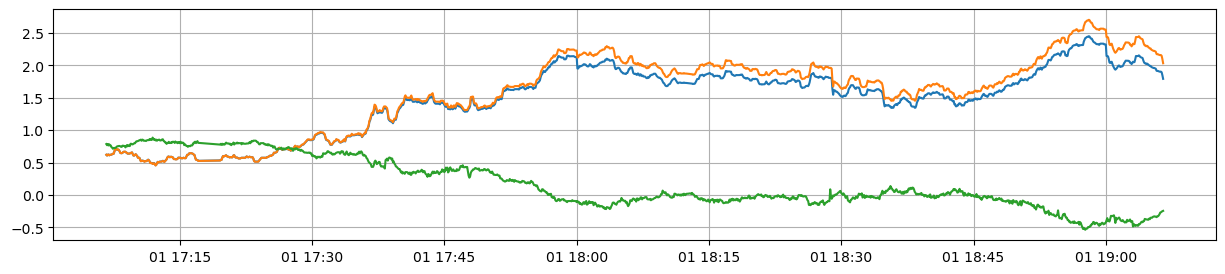

In [10]:
plt.figure(figsize=(15, 3))
plt.plot(lr_df_2h['time'], lr_df_2h['z_score'])
plt.plot(lr_df_2h['time'], lr_df_2h['fixed_z_score'])
plt.plot(lr_df_2h['time'], lr_df_2h['profit'] + 1)

plt.grid();

In [ ]:
def get_open_time_stats(tick_df, agg_df, token_1, token_2, side_1, side_2, open_time, tf, wind, coin_information):
    # Проследить, чтобы tick_df начинался не за wind часов от момента входа, а раньше ещё на несколько часов, чтобы
    # можно было посчитать статы
    
    tick_hist = tick_df.filter(pl.col('time') < open_time).with_columns(
            (pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread')
        )
    agg_hist = agg_df.filter(pl.col('time') < open_time).with_columns(
            (pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread')
        )
    
    # ----- Собираем долговременную статистику -----
    stats = pl.read_parquet('./data/pair_selection/all_pairs.parquet').filter(
            (pl.col('coin1') == token_1) & (pl.col('coin2') == token_2)
        )

    long_std_180d = stats['std_1'][0] if side_1 == 'long' else stats['std_2'][0]
    short_std_180d = stats['std_2'][0] if side_1 == 'long' else stats['std_1'][0]
    long_beta_180d = stats['beta_1'][0] if side_1 == 'long' else stats['beta_2'][0]
    short_beta_180d = stats['beta_2'][0] if side_1 == 'long' else stats['beta_1'][0]
    long_pv = stats['pv_1'][0] if side_1 == 'long' else stats['pv_2'][0]
    short_pv = stats['pv_2'][0] if side_1 == 'long' else stats['pv_1'][0]
    long_btc_corr = stats['coin1_BTC'][0] if side_1 == 'long' else stats['coin2_BTC'][0]
    short_btc_corr = stats['coin2_BTC'][0] if side_1 == 'long' else stats['coin1_BTC'][0]
    long_eth_corr = stats['coin1_ETH'][0] if side_1 == 'long' else stats['coin2_ETH'][0]
    short_eth_corr = stats['coin2_ETH'][0] if side_1 == 'long' else stats['coin1_ETH'][0]
    long_sol_corr = stats['coin1_SOL'][0] if side_1 == 'long' else stats['coin2_SOL'][0]
    short_sol_corr = stats['coin2_SOL'][0] if side_1 == 'long' else stats['coin1_SOL'][0]    

    tls_beta = stats['tls_beta'][0]
    coint = stats['coint'][0]
    hedge_r = stats['hedge_r'][0]
        
    # ----- Собираем статистику за {wind} часов -----
    agg_df_wind = agg_hist.with_columns([
        pl.col(token_1).pct_change().std().alias("vol_1"),
        pl.col(token_2).pct_change().std().alias("vol_2"),
        pl.col('log_spread').mean().alias('mean')
    ])

    mean_wind = agg_df_wind["mean"][0]
    
    long_std_wind = agg_df_wind["vol_1"][0] if side_1 == 'long' else agg_df_wind["vol_2"][0]
    short_std_wind = agg_df_wind["vol_2"][0] if side_1 == 'long' else agg_df_wind["vol_1"][0]
    tls_beta_wind = calculate_tls_beta(agg_df_wind[token_1].to_numpy(), agg_df_wind[token_2].to_numpy())

    # Hurst Exponent за {wind} часов. Аггрегируем данные по 20 минут, чтобы избавиться от шума
    spread_20m = make_trunc_df(tick_hist, '20m', token_1, token_2, method="triple").with_columns(
            (pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread')
        ).filter(pl.col('time') < open_time).tail(3*wind)
    H_wind, _, _ = compute_Hc(spread_20m['log_spread'])

    # ----- Собираем статистику за 12 часов -----
    agg_df_12 = agg_hist.tail(12).with_columns([
        pl.col(token_1).pct_change().std().alias("vol_1"),
        pl.col(token_2).pct_change().std().alias("vol_2"),
        pl.col('log_spread').mean().alias('mean')
    ])

    mean_12 = agg_df_12["mean"][0]
    
    long_std_12 = agg_df_12["vol_1"][0] if side_1 == 'long' else agg_df_12["vol_2"][0]
    short_std_12 = agg_df_12["vol_2"][0] if side_1 == 'long' else agg_df_12["vol_1"][0]
    tls_beta_12 = calculate_tls_beta(agg_df_12[token_1].to_numpy(), agg_df_12[token_2].to_numpy())

    # Hurst Exponent за 12 часов на 5-минутных данных
    spread_5m = make_trunc_df(tick_hist, '5m', token_1, token_2, method="triple").with_columns(
            (pl.col(token_1).log() - pl.col(token_2).log()).alias('log_spread')
        ).filter(pl.col('time') < open_time).tail(12 * 12)
    H_12, _, _ = compute_Hc(spread_5m['log_spread'])

    mean_diff = (mean_12 / mean_wind - 1) * 100 # Изменение среднего значения лог-спреда
    
    # ----- Корреляция между движением z_score и профита за последние 2 часа -----
    start_track_time = open_time - timedelta(hours=2)
    start_track_ts = int(datetime.timestamp(start_track_time))
    end_track_ts = int(datetime.timestamp(open_time))

    tick_2h_df = tick_df.filter(pl.col('time') < open_time)
    hist_2h_df = agg_df.filter(pl.col('time') < open_time)
    
    # Создадим z_score датафрейм за последние 2 часа перед входом в сделку
    lr_df_2h = create_zscore_df(token_1, token_2, tick_2h_df, hist_2h_df, tf, np.array([wind]), start_track_ts, 
                    median_length=6, spr_method='lr'
        ).rename({f'spread_{wind}_{tf}': 'spread', f'spread_mean_{wind}_{tf}': 
                  'spread_mean', f'spread_std_{wind}_{tf}': 'spread_std', f'z_score_{wind}_{tf}': 'z_score'})
    
    # Посчитаем z_score с зафиксированным при входе mean и std
    fixed_mean = lr_df_2h['spread_mean'][0]
    fixed_std = lr_df_2h['spread_std'][0]
    
    lr_df_2h = lr_df_2h.with_columns(
            ((pl.col('spread') - fixed_mean) / fixed_std).alias('fixed_z_score')
        )

    # Создадим столбец с профитом
    t1_op = lr_df_2h[token_1][0]
    t2_op = lr_df_2h[token_2][0]
    t1_qty, t2_qty = get_qty(token_1, token_2, t1_op, t2_op, None, coin_information, 100, method='usdt_neutral')
    lr_df_2h = calculate_profit_curve(lr_df_2h, token_1, token_2, side_1, t1_op, t2_op, t1_qty, t2_qty, fee_rate=0.001)

    # Корреляция между движением профита и z_score
    corr_matrix = lr_df_2h.select('z_score', 'fixed_z_score', 'profit').corr()
    pr_z_corr  = corr_matrix['profit'][0]  # Корреляция между профитом и z_score
    pr_fz_corr = corr_matrix['profit'][1]  # Корреляция между профитом и fixed_z_score
    z_fz_corr  = corr_matrix['z_score'][1] # Корреляция между z_score и fixed_z_score

    if side_1 == 'short':
        pr_z_corr = -pr_z_corr
        pr_fz_corr = -pr_fz_corr

    # Изменение профита и z_score за последние 2 часа
    pr_z_change, pr_fz_change = get_sensitivity(lr_df_2h, side_1)
    sens_favor, sens_adv = get_relative_sensitivity(lr_df_2h, side_1)

    # ----- Расчёт RSI -----
    spread_rsi_1h = rsi(agg_hist, window=14, col_name='log_spread')['rsi'][-1]
    spread_rsi_5m = rsi(spread_5m, window=24, col_name='log_spread')['rsi'][-1]

    rsi_t1_5m = rsi(spread_5m, window=24, col_name=token_1)['rsi'][-1]
    rsi_t2_5m = rsi(spread_5m, window=24, col_name=token_2)['rsi'][-1]
    rsi_t1_1h = rsi(agg_hist, window=14, col_name=token_1)['rsi'][-1]
    rsi_t2_1h = rsi(agg_hist, window=14, col_name=token_2)['rsi'][-1]

    # ----- Расчёт линии тренда, построенной поверх логарифмического спреда -----
    tick_spread_wind = tick_hist['log_spread'].tail(wind * 12 * 60).to_numpy() # Фильтруем только данные за {wind} часов
    tick_spread_12 = tick_hist['log_spread'].tail(12 * 12 * 60).to_numpy()     # Фильтруем только данные за 12 часов
    k_wind, b_wind = lr_coefs(tick_spread_wind)
    k_12, b_12 = lr_coefs(tick_spread_12)
    y_end_wind = k_wind * (len(tick_spread_wind) - 1) + b_wind
    y_end_12 = k_12 * (len(tick_spread_12) - 1) + b_12
    trend_wind = (y_end_wind - b_wind) / b_wind * 100
    trend_12 = (y_end_12 - b_12) / b_12 * 100

    # ----- Расчёт half-life ------
    half_life_log_spread = calculate_half_life(tick_hist['log_spread'].to_numpy()) / 12 / 60


    return lr_df_2h

In [ ]:
tick_2h_df.head(2)

In [ ]:
def run_backtest(dist_df, lr_df, tls_df, params, verbose=2):
    end_date = dist_df['time'][-1]
    tf = params['tf']
    wind = params['wind']
    qty_method = params['qty_method']
    std_1 = params.get('std_1', None)
    std_2 = params.get('std_2', None)
    close_method = params['close_method']
    sl_std = params['sl_std']
    open_method = params['open_method']
    dist_in = params['dist_in']
    dist_out = params['dist_out']
    sl_dist = params['sl_dist']
    force_close = params['force_close']

    dist_df = dist_df.rename({f"spread_{wind}_{tf}": "spread", 
                f"spread_mean_{wind}_{tf}": "spread_mean", 
                f"spread_std_{wind}_{tf}": "spread_std", 
                f"z_score_{wind}_{tf}": "z_score"})

    lr_df = lr_df.rename({f"spread_{wind}_{tf}": "spread",
                f"spread_mean_{wind}_{tf}": "spread_mean", 
                f"spread_std_{wind}_{tf}": "spread_std", 
                f"z_score_{wind}_{tf}": "z_score"})

    tls_df = tls_df.rename({f"spread_{wind}_{tf}": "spread",
                f"spread_mean_{wind}_{tf}": "spread_mean", 
                f"spread_std_{wind}_{tf}": "spread_std", 
                f"z_score_{wind}_{tf}": "z_score"})
    
    print('====== Dist ======')
    trades_dist = backtest(dist_df, token_1, token_2, dp_1, dp_2,
                -params['thresh_in'], -params['thresh_out'], params['thresh_in'], params['thresh_out'],
                long_possible=True, short_possible=True, dist_in=dist_in, dist_out=dist_out,
                balance=100, order_size=50, qty_method=qty_method, std_1=std_1, std_2=std_2,
                fee_rate=0.001, sl_std=sl_std, sl_dist=sl_dist, sl_method='leave', 
                open_method=open_method, close_method=close_method,
                leverage=leverage, force_close=force_close, verbose=verbose)
    if trades_dist.height > 0:
        metrics_dist = analyze_strategy(trades_dist, start_date=valid_time, end_date=end_date, initial_balance=100.0)
        print(f'Max drawdown: {metrics_dist["max_drawdown"]}; profit_ratio: {metrics_dist["profit_ratio"]}')

    print('\n====== LR ======')
    trades_lr = backtest(lr_df, token_1, token_2, dp_1, dp_2,
                -params['thresh_in'], -params['thresh_out'], params['thresh_in'], params['thresh_out'],
                long_possible=True, short_possible=True, dist_in=dist_in, dist_out=dist_out,
                balance=100, order_size=50, qty_method=qty_method, std_1=std_1, std_2=std_2,
                fee_rate=0.001, sl_std=sl_std, sl_dist=sl_dist, sl_method='leave', 
                open_method=open_method, close_method=close_method,
                leverage=leverage, force_close=force_close, verbose=verbose)
    if trades_lr.height > 0:
        metrics_lr = analyze_strategy(trades_lr, start_date=valid_time, end_date=end_date, initial_balance=100.0)
        print(f'Max drawdown: {metrics_lr["max_drawdown"]}; profit_ratio: {metrics_lr["profit_ratio"]}')

    print('\n====== TLS ======')
    trades_tls = backtest(tls_df, token_1, token_2, dp_1, dp_2,
                -params['thresh_in'], -params['thresh_out'], params['thresh_in'], params['thresh_out'],
                long_possible=True, short_possible=True, dist_in=dist_in, dist_out=dist_out,
                balance=100, order_size=50, qty_method=qty_method, std_1=std_1, std_2=std_2,
                fee_rate=0.001, sl_std=sl_std, sl_dist=sl_dist, sl_method='leave', 
                open_method=open_method, close_method=close_method,
                leverage=leverage, force_close=force_close, verbose=verbose)
    if trades_tls.height > 0:
        metrics_tls = analyze_strategy(trades_tls, start_date=valid_time, end_date=end_date, initial_balance=100.0)
        print(f'Max drawdown: {metrics_tls["max_drawdown"]}; profit_ratio: {metrics_tls["profit_ratio"]}')

    return trades_dist, trades_lr, trades_tls

In [ ]:
params = {'tf': '1h', 'wind': 64, 'thresh_in': 1.8, 'thresh_out': 0.25, 'qty_method': 'usdt_neutral',
         'std_1': std_1, 'std_2': std_2, 'sl_std': 8.0, 'sl_dist': 0.1, 'open_method': 'reverse_static', 'close_method': 'direct',
         'dist_in': 0.5, 'dist_out': 0.0, 'force_close': False}

trades_dist, trades_lr, trades_tls = run_backtest(dist_df, lr_df, tls_df, params, verbose=2)

In [ ]:
curr_df = agg_df.drop('log_spread').vstack(tick_df.select('time', 'ts', 'EIGEN', 'OP').tail(1)).tail(96)

In [ ]:
curr_df

In [ ]:
x = curr_df['EIGEN'].to_numpy()
y = curr_df['OP'].to_numpy()

In [ ]:
get_tls_zscore(x, y, np.array([96]))

In [ ]:
from bot.analysis.backtesting_class import Sim

In [ ]:
def get_sensitivity(z_score_arr, profit_array):
    dz = np.diff(z_score_arr)
    dvu = np.diff(profit_array)
    
    mask = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001)
    mask_pos = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001) & (dz > 0)
    mask_neg = (np.abs(dz) >= 0.0001) & (np.abs(dvu) >= 0.0001) & (dz < 0)
    
    dvu_dz = dvu[mask] / dz[mask]
    dvu_dz_pos = dvu[mask_pos] / dz[mask_pos]
    dvu_dz_neg = dvu[mask_neg] / dz[mask_neg]

    return np.mean(dvu_dz), np.mean(dvu_dz_pos), np.mean(dvu_dz_neg)

def get_corr(z_score_array, profit_array, n_obs=1_000_00):
    z_arr = z_score_array[~np.isnan(z_score_array)][-n_obs:]
    pr_arr = profit_array[~np.isnan(profit_array)][-n_obs:]
    return np.corrcoef(z_arr, pr_arr)[0][1]

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
token_1 = 'EGLD'
token_2 = 'TON'
# close_method = 'reg' # 'fix' or 'reg'

test_in = 1.6
in_ = 2.25
out_ = 0.25
delete_dist = 0.2
sl_std = 5.0

params = {'fee_rate': 0.001, 'min_order': 42, 'close_method': 'reg'}
valid_time = datetime(2025, 11, 28, 12, 0, 0, tzinfo=ZoneInfo('Europe/Moscow'))
# end_time   = datetime(2025, 11, 22, 12, 20, 34, tzinfo=ZoneInfo('Europe/Moscow'))

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

bt = Sim(token_1, token_2, tf='1h', wind=96, valid_time=valid_time, params=params)
bt.reset_trade()
full_df, valid_df, hist_df = bt.load_data()

In [ ]:
plt.figure(figsize=(15, 2))

plt.plot(valid_df['time'], valid_df['z_score'], c='blue', label='dist')
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
plt.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
plt.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
plt.axhline(y=0.25, color='red', linestyle='--', linewidth=1)
plt.grid();

In [ ]:
time_arr = valid_df['time'].to_numpy()
tss = valid_df['ts'].to_numpy()
avg_price1 = full_df[token_1].to_numpy()
avg_price2 = full_df[token_2].to_numpy()
bid_1 = full_df[f"{token_1}_bid_price"].to_numpy()
ask_1 = full_df[f"{token_1}_ask_price"].to_numpy()
bid_2 = full_df[f"{token_2}_bid_price"].to_numpy()
ask_2 = full_df[f"{token_2}_ask_price"].to_numpy()

hist_tss = hist_df['ts'].to_numpy()
hist_t1 = hist_df[token_1].to_numpy()
hist_t2 = hist_df[token_2].to_numpy()

In [ ]:
stats = pl.read_parquet('./data/pair_selection/all_pairs.parquet').filter(
                (pl.col('coin1') == token_1) & (pl.col('coin2') == token_2)
            )
stats

In [ ]:
%%time
nrows = tss.shape[0]
ts_arr = np.full(nrows, np.nan)
z_score_arr = np.full(nrows, np.nan)
fixed_dist_z_arr = np.full(nrows, np.nan)
profit_arr = np.full(nrows, np.nan)
spread_arr = np.full(nrows, np.nan)
corr_arr = np.full(nrows, np.nan)

tracking_fix_zscore_dist = np.full(nrows, np.nan)

eps = 0.000001
mask = (np.abs(z_score_arr) >= eps) & (np.abs(profit_arr) >= eps)  & (np.abs(fixed_dist_z_arr) >= eps)

full_dist_spread = np.full(nrows, np.nan)

tracking_profit = np.full(nrows, np.nan)
tracking_zscore = np.full(nrows, np.nan)

POS_NONE, TRACKING_LONG, TRACKING_SHORT, POS_LONG, POS_SHORT = 0, 1, 2, 3, 4

for i in range(nrows):
    tm_np = time_arr[i]
    tm = np.datetime_as_string(tm_np, unit='s').replace('T', ' ')
    t1_price = avg_price1[i]
    t2_price = avg_price2[i]
    spread = np.log(t1_price) - np.log(t2_price)
    close_price_1 = ask_1[i] if bt.side_1 == 'short' else bid_1[i]
    close_price_2 = ask_2[i] if bt.side_1 == 'long' else bid_2[i]

    # Подготовим данные за прошедшее время для подсчёта статов при входе в сделку
    hist_mask = hist_tss < tss[0]
    t1_24h = hist_t1[hist_mask][-24:]
    t2_24h = hist_t2[hist_mask][-24:]

    t1_wind = hist_t1[hist_mask][-bt.wind:]
    t2_wind = hist_t2[hist_mask][-bt.wind:]

    # Сформируем массивы, в которых к историческим данным в конец добавим текущую медианную цену, и посчитаем z_score
    t1_arr = np.append(t1_wind, t1_price)
    t2_arr = np.append(t2_wind, t2_price)
    spread_mean, spread_std, z_score = get_dist_zscore(t1_arr, t2_arr, np.array([bt.wind]))
    
    z_score = z_score[0]
    full_dist_spread[i] = spread
        
    # ------------ Обработка новой пары ------------
    if bt.pos_side == POS_NONE:
        if z_score < -test_in:
            print(f'{tm} Начинаем отслеживать long-пару {token_1} - {token_2}')
            
            bt.test_fixed_mean, bt.test_fixed_std = spread_mean[0], spread_std[0]
            print(f'{tm} Фиксируем среднее значение спреда {bt.test_fixed_mean:.4f} и std {bt.test_fixed_std:.4f}')
            bt.test_price_1 = ask_1[i]
            bt.test_price_2 = bid_2[i]
            bt.side_1 = 'long'
            bt.side_2 = 'short'
            bt.test_qty_1, bt.test_qty_2 = get_qty(token_1, token_2, bt.test_price_1, bt.test_price_2, None, coin_information, 
                       200, 0.001, None, None, method='usdt_neutral')
            fees = (bt.test_qty_1 * bt.test_price_1 + bt.test_qty_2 * bt.test_price_2) * bt.fee_rate * 2
            
            tracking_zscore[i] = z_score
            tracking_profit[i] = -fees
            bt.pos_side = TRACKING_LONG
            print(f'qty_1: {bt.test_qty_2}; qty_2: {bt.test_qty_1}; price_1: {bt.test_price_1}; price_2: {bt.test_price_2}')
        
        elif z_score > test_in:
            print(f'{tm} Начинаем отслеживать short-пару {token_1} - {token_2}')

            bt.test_fixed_mean, bt.test_fixed_std = spread_mean[0], spread_std[0]
            print(f'{tm} Фиксируем среднее значение спреда {bt.test_fixed_mean:.4f} и std {bt.test_fixed_std:.4f}')
            
            bt.test_price_1 = bid_1[i]
            bt.test_price_2 = ask_2[i]
            bt.side_1 = 'short'
            bt.side_2 = 'long'
            bt.test_qty_1, bt.test_qty_2 = get_qty(token_1, token_2, bt.test_price_1, bt.test_price_2, None, coin_information, 
                       200, 0.001, None, None, method='usdt_neutral')
            fees = (bt.test_qty_1 * bt.test_price_1 + bt.test_qty_2 * bt.test_price_2) * bt.fee_rate * 2
            
            tracking_zscore[i] = z_score
            tracking_profit[i] = -fees
            bt.pos_side = TRACKING_SHORT
                    
    # ------------ Обработка входа в позицию ------------
    elif bt.pos_side == TRACKING_LONG:
        # tracking_zscore[~np.isnan(tracking_zscore)]
        
        bt.test_profit_1 = calculate_profit(bt.test_price_1, bid_1[i], bt.qty_1, bt.side_1)
        bt.test_profit_2 = calculate_profit(bt.test_price_2, ask_2[i], bt.qty_2, bt.side_2)
        bt.test_profit = bt.test_profit_1 + bt.test_profit_2
        tracking_zscore[i] = z_score
        tracking_profit[i] = bt.test_profit

        bt.test_fixed_zscore = (spread - bt.test_fixed_mean) / bt.test_fixed_std
        tracking_fix_zscore_dist[i] = bt.test_fixed_zscore
        
        # Если z_score выходит из зоны входа в позицию, перестаём отслеживать пару
        if z_score > -test_in + delete_dist:
            print(f'{tm} Удаляем пару {token_1} - {token_2} из трекинга (z_score: {z_score:.3f})')
            bt.reset_test_period()
            tracking_profit = np.full(nrows, np.nan)
            tracking_zscore = np.full(nrows, np.nan)
            continue
        
        if z_score < -in_:
            print(f'{tm} Открываем лонг-позицию. z_score: {z_score:.3f}')

            # Сначала сохраняем данные трекингового периода и считаем статистики
            # do_something()

            vol24_1 = t1_24h.std()
            vol24_2 = t2_24h.std()
            vol_wind_1 = t1_wind.std()
            vol_wind_2 = t2_wind.std()
            
            # --------------- Выводим важную инфу на экран --------------
            print(f'Std. 24h: {vol24_1:.4f} / {vol24_2:.4f} ({vol24_1 / vol24_2:.4f})', end='; ')
            print(f'{bt.wind}h: {vol_wind_1:.4f} / {vol_wind_2:.4f} ({vol_wind_1 / vol_wind_2:.4f})', end='; ')
            print(f"180d: {stats['std_1'][0]:.4f} / {stats['std_2'][0]:.4f} ({stats['std_1'][0] / stats['std_2'][0]:.4f})")
            break

            dvu_dz, dvu_dz_pos, dvu_dz_neg = get_sensitivity(z_score_array, profit_array)
            print(f'Чуствительность: {dvu_dz:.3f}; pos: {dvu_dz_pos:.3f}; neg: {dvu_dz_neg:.3f}')

             # -----------------------------------------------------------

            bt.open_price_1 = ask_1[i]
            bt.open_price_2 = bid_2[i]
            bt.side_1 = 'long'
            bt.side_2 = 'short'
            bt.qty_1, bt.qty_2 = get_qty(token_1, token_2, bt.open_price_1, bt.open_price_2, None, coin_information, 
                       200, 0.001, None, None, method='usdt_neutral')

            fees = (bt.qty_1 * bt.open_price_1 + bt.qty_2 * bt.open_price_2) * bt.fee_rate * 2
            
            profit_arr[i] = -fees
            z_score_arr[i] = z_score
            
            bt.pos_side = POS_LONG
            bt.reset_test_period()
            tracking_profit = np.full(nrows, np.nan)
            tracking_zscore = np.full(nrows, np.nan)
            break
        
    # Обновляем z_score и profit для потенциальной short-позиции
    elif bt.pos_side == TRACKING_SHORT:
        bt.test_profit_1 = calculate_profit(bt.test_price_1, ask_1[i], bt.qty_1, bt.side_1)
        bt.test_profit_2 = calculate_profit(bt.test_price_2, bid_2[i], bt.qty_2, bt.side_2)
        bt.test_profit = bt.test_profit_1 + bt.test_profit_2
        
        tracking_zscore[i] = z_score
        tracking_profit[i] = bt.test_profit

        bt.test_fixed_zscore = (spread - bt.test_fixed_mean) / bt.test_fixed_std
        tracking_fix_zscore_dist[i] = bt.test_fixed_zscore
        
        # Если z_score выходит из зоны входа в позицию, перестаём отслеживать пару
        if z_score < test_in - delete_dist:
            print(f'{tm} Удаляем пару {token_1} - {token_2} из трекинга (z_score: {z_score:.3f})')
            bt.reset_test_period()
            tracking_profit = np.full(nrows, np.nan)
            tracking_zscore = np.full(nrows, np.nan)
            continue
        
        if z_score > in_:
            print(f'{tm} Открываем шорт-позицию. z_score: {z_score:.3f}')
            
            z_score_array = np.array(tracking_short[(token_1, token_2)][0])
            profit_array = np.array(tracking_short[(token_1, token_2)][1])

            dvu_dz, dvu_dz_pos, dvu_dz_neg = get_sensitivity(z_score_array, profit_array)
            print(f'Чуствительность: {dvu_dz:.3f}; pos: {dvu_dz_pos:.3f}; neg: {dvu_dz_neg:.3f}')

            open_price_1 = bid_1[i]
            open_price_2 = ask_2[i]
            qty_1, qty_2 = get_qty(token_1, token_2, open_price_1, open_price_2, None, coin_information, 
                       200, 0.001, None, None, method='usdt_neutral')

            fees = (qty_1 * open_price_1 + qty_2 * open_price_2) * fee_rate * 2
            
            bt.pos_side = POS_SHORT
            bt.reset_test_period()
            tracking_profit = np.full(nrows, np.nan)
            tracking_zscore = np.full(nrows, np.nan)
            break
            
    
    # ------------ Обработка выхода из позиции ------------
    # if bt.pos_side == POS_LONG:
    #     curr_profit_1 = calculate_profit(open_price_1, bid_1[i], qty_1, side_1)
    #     curr_profit_2 = calculate_profit(open_price_2, ask_2[i], qty_2, side_2)
    #     curr_profit = curr_profit_1 + curr_profit_2

    #     z_score_arr[i] = z_score
    #     profit_arr[i] = curr_profit
    #     spread_arr[i] = spread
        
    #     fixed_z_score = (spread - fixed_mean) / fixed_std
    #     fixed_z_arr[i] = fixed_z_score
        
    #     # Сохраняем текущую корреляцию
    #     zsc = z_score_arr[~np.isnan(z_score_arr)]
    #     pr = spread_arr[~np.isnan(spread_arr)]
    #     corr_arr[i] = np.corrcoef(zsc, pr)[0][1]
        
    #     out_condition = z_score if close_method == 'reg' else fixed_z_score
        
    #     # Проверяем стоп-лосс
    #     if abs(fixed_z_score) > sl_std:
    #         print(f'{tm} STOP-LOSS! Закрываем long-позицию. z_score: {z_score:.3f}, fixed z_score: {fixed_z_score:.3f}, profit: {curr_profit:.2f}')
    #         break
        
    #     if out_condition > out_:
    #         print(f'{tm} Закрываем long-позицию. z_score: {z_score:.3f}, profit: {curr_profit:.2f}')
    #         bt.pos_side = POS_NONE
    #         open_price_1, open_price_2, qty_1, qty_2 = None, None, None, None
    #         fixed_mean, fixed_std = None, None
    #         side_1, side_2 = '', ''
    #         continue
    
    # if bt.pos_side == POS_SHORT:
    #     curr_profit_1 = calculate_profit(open_price_1, ask_1[i], qty_1, side_1)
    #     curr_profit_2 = calculate_profit(open_price_2, bid_2[i], qty_2, side_2)
    #     curr_profit = curr_profit_1 + curr_profit_2
        
    #     z_score_arr[i] = z_score
    #     profit_arr[i] = curr_profit
    #     spread_arr[i] = spread
        
    #     fixed_z_score = (spread - fixed_mean) / fixed_std
    #     fixed_z_arr[i] = fixed_z_score
        
    #     # Сохраняем текущую корреляцию
    #     zsc = z_score_arr[~np.isnan(z_score_arr)]
    #     pr = spread_arr[~np.isnan(spread_arr)]
    #     corr_arr[i] = np.corrcoef(zsc, pr)[0][1]

    #     out_condition = z_score if close_method == 'reg' else fixed_z_score

    #     # Проверяем стоп-лосс
    #     if abs(fixed_z_score) > sl_std:
    #         print(f'{tm} STOP-LOSS! Закрываем short-позицию. z_score: {z_score:.3f}, fixed z_score: {fixed_z_score:.3f}, profit: {curr_profit:.2f}')
    #         break
    #     if out_condition < -out_:
    #         print(f'{tm} Закрываем шорт-позицию. z_score: {z_score:.3f}, profit: {curr_profit:.2f}')
    #         bt.pos_side = POS_NONE
    #         open_price_1, open_price_2, qty_1, qty_2 = None, None, None, None
    #         fixed_mean, fixed_std = None, None
    #         bt.side_1, bt.side_2 = '', ''
    #         continue


In [ ]:
not_null_tracking_zscore = tracking_zscore[~np.isnan(tracking_zscore)]
not_null_tracking_profit = tracking_profit[~np.isnan(tracking_profit)]

In [ ]:
not_null_tracking_zscore

In [ ]:
spread_mean

In [ ]:
calculate_half_life(not_null_tracking_zscore)

In [ ]:
not_null_tracking_zscore.mean()

In [ ]:
print(f'Mean. 24h: {t1_24h.mean():.4f}')

In [ ]:
spread_arr

In [ ]:
mask = (np.abs(z_score_arr) >= 0.0001) & (np.abs(profit_arr) >= 0.0001)  & (np.abs(fixed_z_arr) >= 0.0001)
zsc = z_score_arr[mask]
spr = spread_arr[mask]
pr = profit_arr[mask]
fxz = fixed_z_arr[mask]
cr = corr_arr[~np.isnan(corr_arr)]
tls_zsc = tls_z_score_arr[mask]
tls_fxz = fixed_tls_z_arr[mask]

dz = np.diff(zsc)
dpr = np.diff(pr)
eps = 0.0000001
mask = (np.abs(dz) >= eps) & (np.abs(dpr) >= eps)
mask_pos = (np.abs(dz) >= eps) & (np.abs(dpr) >= eps) & (dz > 0)
mask_neg = (np.abs(dz) >= eps) & (np.abs(dpr) >= eps) & (dz < 0)

dpr_dz = dpr[mask] / dz[mask]
dpr_dz_pos = dpr[mask_pos] / dz[mask_pos]
dpr_dz_neg = dpr[mask_neg] / dz[mask_neg]

avg_dpr_dz = moving_average(dpr_dz, n=120)
avg_pos_dz = moving_average(dpr_dz_pos, n=120)
avg_neg_dz = moving_average(dpr_dz_neg, n=120)

In [ ]:
def plot_spread():
    x = range(len(zsc))

    k, b = lr_coefs(spr)
    regression_line = k * x + b

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
    ax1.plot(x, zsc, c='blue', label='z_score')
    ax1.plot(x, fxz, c='gray', label='fixed z_score')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax1.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
    ax1.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
    ax1.set_title('Dist z_score & spread')
    ax1.grid();
    ax1.legend()

    ax11 = ax1.twinx()
    ax11.plot(x, spr, c='green', label='spread')
    ax11.plot(x, regression_line, c='green', linewidth=2)
    
    ax2.plot(x, tls_zsc, c='blue', label='tls z_score')
    ax2.plot(x, tls_fxz, c='gray', label='fixed tls')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
    ax2.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
    ax2.set_title('TLS z_score & spread')
    ax2.grid();
    ax2.legend()

    ax12 = ax2.twinx()
    ax12.plot(range(len(full_tls_spread)), full_tls_spread, c='green')
    
    ax3.plot(x, pr, c='red')
    ax3.grid()
    ax3.set_title('Profit')
    
    # ax4.set_title('Sensitivity')
    # ax3.plot(range(len(avg_pos_dz)), avg_pos_dz, c='green', label='positive')
    # ax3.plot(range(len(avg_neg_dz)), avg_neg_dz, c='red', label='negative')
    # ax3.legend()
    # ax3.set_ylim(-50, 50)
    # ax3.grid();
    
    ax4.plot(range(len(cr)), cr, c='green', label='corr', linewidth=2)
    ax4.set_title('Correlation')
    ax4.set_ylim(-1, 1)
    ax4.grid()
    
    fig.tight_layout()

In [ ]:
plot_spread()

In [ ]:
fxz.min()

In [ ]:
corr_usdt = np.corrcoef(zsc, pr)[0][1]
corr_usdt

In [ ]:
np.mean(dpr_dz), np.mean(dpr_dz_pos), np.mean(dpr_dz_neg)

In [ ]:
len(dpr_dz_pos),len(dpr_dz_neg)

In [ ]:
len(dpr_dz_pos) * np.mean(dpr_dz_pos) - len(dpr_dz_neg) * np.mean(dpr_dz_neg)

In [ ]:
dpr_dz_pos.sum(), -dpr_dz_neg.sum()

In [ ]:
zsc

In [ ]:
start, stop = 240, 360
round(float(dz[start:stop].sum()), 4), round(float(dpr[start:stop].sum()), 4)

In [ ]:
0.3311 / 0.193, -0.7224 / -0.4186, 0.0645/0.0649

In [ ]:
fig, ax1 = plt.subplots(figsize=(4, 4))
ax1.scatter(dz, dpr)
ax1.grid();

In [ ]:
len(z_score_array), len(profit_array)

In [ ]:
n = 50

fig, ax1 = plt.subplots(1, 1, figsize=(15, 3))
ax1.plot(range(n), z_score_array[-n:], label=f'z_score', c='blue')
ax1.set_ylabel('z_score')
ax2 = ax1.twinx()
ax2.plot(range(n), profit_array[-n:], label=f'profit', c='green')
ax2.set_ylabel('usdt')
plt.tight_layout()

In [ ]:
token_1 = 'ARKM'
token_2 = 'MANTA'

open_time = datetime(2025, 11, 27, 8, 30, 0, tzinfo=ZoneInfo('Europe/Moscow'))
close_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
open_ts = int(datetime.timestamp(open_time))
close_ts = int(datetime.timestamp(close_time))

z_score_hist = db_manager.get_zscore_history(token_1 + '_USDT', token_2 + '_USDT', open_ts, close_ts)
len(z_score_hist)

In [ ]:
z_score_hist.tail(2)

In [ ]:
tdf = dist_df.filter((pl.col('time') >= open_time) & (pl.col('time') <= close_time))

fig, ax1 = plt.subplots(figsize=(14, 3))
ax1.plot(tdf['time'], tdf[f'z_score_{wind}_{tf}'], c='blue', label='calc z_score')
ax1.plot(z_score_hist['time'], z_score_hist['z_score'], c='green', label='real z_score')
ax1.plot(z_score_hist['time'], z_score_hist['fixed_z_score'], c='gray', label='fixed z_score')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax1.axhline(y=-2.5, color='green', linestyle='--', linewidth=1)
ax1.axhline(y=2.5, color='green', linestyle='--', linewidth=1)
ax1.axhline(y=-0.25, color='red', linestyle='--', linewidth=1)
ax1.axhline(y=0.25, color='red', linestyle='--', linewidth=1)

ax2 = ax1.twinx()
ax2.plot(z_score_hist['time'], z_score_hist['profit'], c='red', label='profit')

ax1.grid();
plt.legend();

In [ ]:
tdf = z_score_hist.filter(pl.col('fixed_z_score') > -10)

In [ ]:
tdf.select('z_score','profit', 'fixed_z_score', 'spread').corr()

In [ ]:
z_score_hist = z_score_hist.with_columns(
    pl.rolling_corr(
        a="z_score",         # Первый столбец
        b="profit",          # Второй столбец
        window_size=720,     # Размер скользящего окна
        ddof=1               # Степени свободы для дисперсии
    ).alias("rolling_corr")
)

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 3))
ax1.plot(z_score_hist['time'], z_score_hist['rolling_corr'])
ax1.grid();

# ax2 = ax1.twinx()
# ax2.plot(range(len(r_corr)), r_corr, c='red', label='numpy')

#### Обработка больших датафреймов

In [ ]:
from tqdm.notebook import tqdm
import polars as pl
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from bot.utils.files import load_config

config = load_config('./bot/config/config.yaml')

method = config['spr_method']
start_time = config['valid_time']
end_time = config['end_time']

In [ ]:
token_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))
len(token_pairs)

In [ ]:
# --- Создание объединённого датафрейма из нескольких ---
tfs = ('1h', )
method = 'dist'

time_series = pl.datetime_range(start=start_time, end=end_time, interval="5s", eager=True)
main_df = pl.DataFrame({'time': time_series})

for token_1, token_2 in tqdm(token_pairs):
    try:
        spread_df = pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_1h_{method}.parquet', 
                low_memory=True, rechunk=True, use_pyarrow=True).filter(
                (pl.col('time') >= start_time) & (pl.col('time') < end_time)
            )

        cols_to_rn = [col for col in spread_df.columns for tf in tfs if col.endswith(tf)]
        prefix = f"{token_1}_{token_2}_"
        mapping = {c: f"{prefix}{c}" for c in cols_to_rn}
        spread_df = spread_df.rename(mapping)

        cols_to_drop = [col for col in spread_df.columns if col in main_df.columns]
        cols_to_drop.remove('time')
        spread_df = spread_df.drop(cols_to_drop)

        main_df = main_df.join(spread_df, on='time', how='full', coalesce=True)
    except FileNotFoundError:
        print(f'FileNotFoundError: {token_1} - {token_2}')
        continue

In [ ]:
spr_cols = [col for col in main_df.columns if 'spread' in col]
main_df.drop(spr_cols).tail(3)

In [ ]:
main_df.tail(10)

In [ ]:
main_df[1:-1].drop(spr_cols).write_parquet('./data/train_data.parquet')

In [ ]:
# --- Код для склеивания по частям двух датафреймов, записанных на диске, в один ---
import polars as pl

df_1 = pl.read_parquet('./data/test_1.parquet', low_memory=True, use_pyarrow=True)
df_2 = pl.read_parquet('./data/test_2.parquet', low_memory=True, use_pyarrow=True)
print(df_1.shape, df_2.shape)

full_df = df_1.join(df_2[:, :500], on='time', how='full', coalesce=True)
full_df.write_parquet(f'./data/full_1.parquet')

cols_to_drop = df_2[:, :500].columns
cols_to_drop.remove('time')
df_2 = df_2.drop(cols_to_drop)
print(full_df.shape, df_2.shape)

df_2.write_parquet(f'./data/full_2.parquet')

In [ ]:
token_1 = 'JUP'
token_2 = 'MANA'
method = 'dist'

In [ ]:
pl.read_parquet(f'./data/pair_backtest/{token_1}_{token_2}_{method}_full.parquet', 
                low_memory=True, rechunk=True, use_pyarrow=True)